In [2]:
!pip install -e ../../geoai

Obtaining file:///Users/dikaizm/Documents/PROGRAMMING/machine-learning/research-crop-mapping-thesis/geoai
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for geoai-py (pyproject.toml) ... done
  Created wheel for geoai-py: filename=geoai_py-0.12.0-0.editable-py2.py3-none-any.whl size=7701 sha256=4ec09a337b0b649c7eed410d48f353d56560c4c000254c09b91851caf50c7131
  Stored in directory: /private/var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/pip-ephem-wheel-cache-yyai0xvv/wheels/90/da/b6/56765eee06e66ad757c102a2ea5ba089cd6eafd5b07a0af024
Successfully built geoai-py
  Attempting uninstall: geoai-py
    Found existing installation: geoai-py 0.12.0
    Uninstalling geoai-py-0.12.0:
      Successfully uninstalled geoai-py-0.12.0

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip 

In [3]:
import geoai

In [7]:
data_dir = "../data"

train_path = f"{data_dir}/train/S2H_2023_2023_05_01_nodata.tif"
label_path = f"{data_dir}/labels/2024_30m_cdls_resampled_filtered.tif"
label_path_vector = f"{data_dir}/labels/2024_30m_cdls_resampled.geojson"

In [5]:
geoai.get_raster_info(train_path)

{'driver': 'GTiff',
 'width': 7217,
 'height': 5495,
 'count': 9,
 'dtype': 'float64',
 'crs': 'EPSG:4326',
 'transform': Affine(8.983152847443538e-05, 0.0, -122.075297894,
        0.0, -8.983152848043673e-05, 39.176787182),
 'bounds': BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182),
 'resolution': (8.983152847443538e-05, 8.983152848043673e-05),
 'nodata': -9999.0,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 19944.0,
   'mean': 639.1254983615107,
   'std': 353.2116881281851},
  {'band': 2,
   'min': 0.0,
   'max': 18488.0,
   'mean': 932.0045798903543,
   'std': 384.5503780499244},
  {'band': 3,
   'min': 0.0,
   'max': 17416.0,
   'mean': 1027.0463133696933,
   'std': 542.0625909614504},
  {'band': 4,
   'min': 0.0,
   'max': 17033.0,
   'mean': 1411.10579038535,
   'std': 489.2619091145002},
  {'band': 5,
   'min': 0.0,
   'max': 16769.0,
   'mean': 2124.313831323854,
   'std': 851.9892474576448},
  {'band': 6,
   'min': 0.0,
   

In [9]:
# geoai.view_raster_with_labels(train_path, label_path)

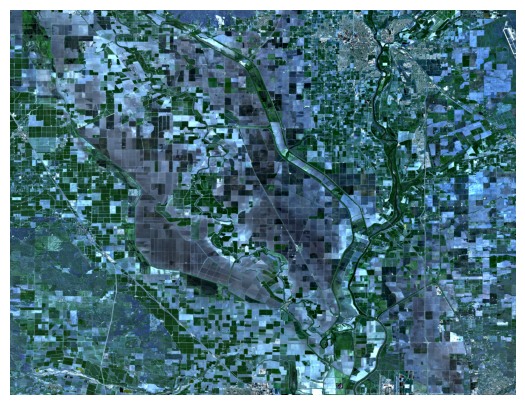

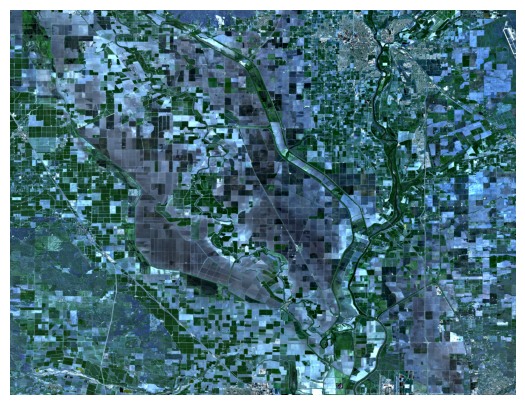

In [50]:
geoai.view_image(train_path)

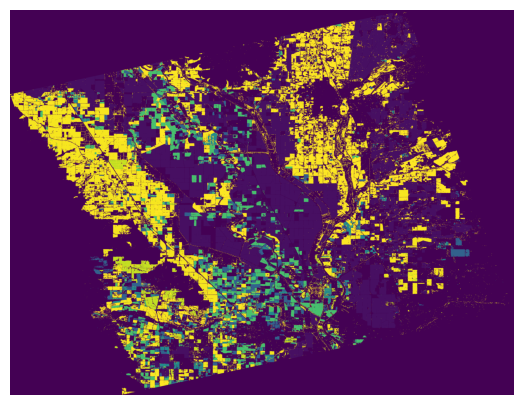

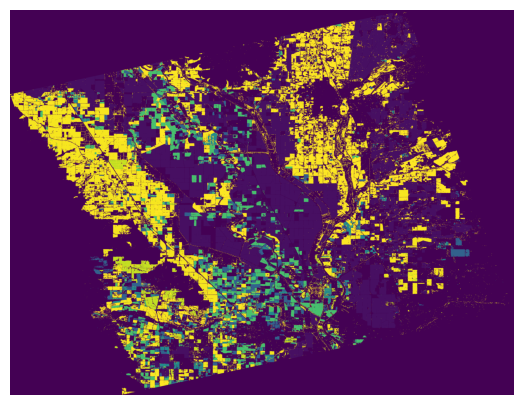

In [10]:
geoai.view_image(label_path)

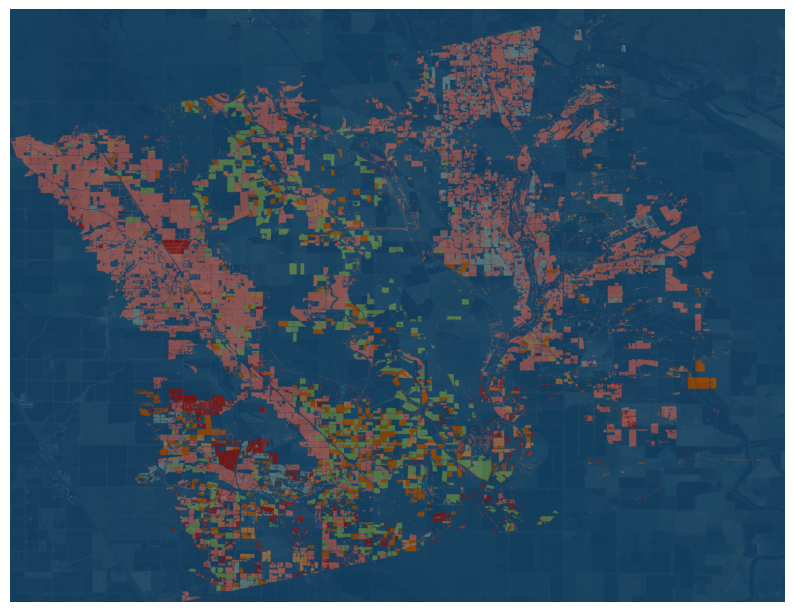

In [12]:
import rasterio
import matplotlib.pyplot as plt

# Open Sentinel-2
with rasterio.open(train_path) as src:
    s2 = src.read([4,3,2])  # RGB bands
    s2 = s2.transpose(1,2,0)  # reshape for plotting

# Open CDL
with rasterio.open(label_path) as src:
    cdl = src.read(1)

plt.figure(figsize=(10,10))
plt.imshow(s2 / s2.max())  # normalize Sentinel-2 RGB
plt.imshow(cdl, alpha=0.5, cmap="tab20")  # overlay CDL
plt.axis("off")
plt.show()

In [13]:
import os

out_name = "crop_mapping"
data_folder = f"../data/processed/{out_name}"

model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

# this function will create folders (annotations, images, labels)
tiles = geoai.export_geotiff_tiles(
    in_raster=train_path,
    out_folder=data_folder,
    in_class_data=label_path,
    tile_size=256,
    stride=256,
    buffer_radius=0,
)

Detected in_class_data as raster: ../data/labels/2024_30m_cdls_resampled_filtered.tif
Raster CRS: EPSG:4326
Raster dimensions: 2958 x 2262

Raster info for ../data/train/S2H_2023_2023_05_01_nodata.tif:
  CRS: EPSG:4326
  Dimensions: 7217 x 5495
  Resolution: (8.983152847443538e-05, 8.983152848043673e-05)
  Bands: 9
  Bounds: BoundingBox(left=-122.075297894, bottom=38.683162933, right=-121.426983753, top=39.176787182)
Found 10 unique classes in raster: [  1.   3.  24.  36.  54.  69.  75.  76. 210. 211.]


Generated: 638, With features: 634: 100%|██████████| 638/638 [00:06<00:00, 104.12it/s]



------- Export Summary -------
Total tiles exported: 638
Tiles with features: 634 (99.4%)
Average feature pixels per tile: 74868.0
Output saved to: ../data/processed/crop_mapping

------- Georeference Verification -------


In [14]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{data_folder}/images",
    labels_dir=f"{data_folder}/labels",
    output_dir=f"{model_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=9,
    num_classes=10,  # background and building
    batch_size=8,
    num_epochs=40,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

Using device: mps
Found 638 image files and 638 label files
Training on 510 images, validating on 128 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,456,490
Epoch: 1, Batch: 1/64, Loss: 2.2107, Time: 0.96s
Epoch: 1, Batch: 11/64, Loss: 1.6829, Time: 1.78s
Epoch: 1, Batch: 21/64, Loss: 1.4318, Time: 1.55s
Epoch: 1, Batch: 31/64, Loss: 1.6595, Time: 1.60s
Epoch: 1, Batch: 41/64, Loss: 1.0147, Time: 1.83s
Epoch: 1, Batch: 51/64, Loss: 1.6767, Time: 1.61s
Epoch: 1, Batch: 61/64, Loss: 1.3078, Time: 1.62s


KeyboardInterrupt: 